In [1]:
from pathlib import Path
import os

# Detectar automáticamente si estamos en portátil o sobremesa
possible_roots = [
    Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak"),  # sobremesa
    Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak")  # portátil
]

for path in possible_roots:
    if path.exists():
        project_root = path
        break
else:
    raise FileNotFoundError("⚠️ Ninguna ruta válida encontrada para project_root.")

# Establecer como directorio de trabajo
os.chdir(project_root)
print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


In [2]:
# ----------------------------------------------
# 🎯 FUTPEAK — Etapa 1: Carga y revisión inicial de los datos
# ----------------------------------------------

# 📌 Objetivo de esta celda:
# - Cargar los datasets base: logs de partidos (matchlogs) y metadatos de jugadores (metadata)
# - Hacer una revisión general de columnas, tipos, nulos y duplicados
# - Validar que ambas tablas están listas para ser combinadas y utilizadas en el modelado
# ----------------------------------------------

import pandas as pd
from pathlib import Path

# 📁 Ruta base donde están los datos procesados (ajustada a la estructura del proyecto)
data_path = Path("data/processed")

# 🧾 Archivos CSV de interés
matchlogs_path = data_path / "cleaned_matchlogs.csv"
metadata_path = data_path / "cleaned_metadata.csv"

# ----------------------------------------------
# 📥 Función de carga segura con información básica
# ----------------------------------------------
def load_csv(path, name):
    """
    Carga un CSV desde la ruta dada y muestra su tamaño.
    Si hay error, devuelve un DataFrame vacío.
    """
    try:
        df = pd.read_csv(path)
        print(f"✅ {name} cargado correctamente: {df.shape[0]} filas, {df.shape[1]} columnas.")
        return df
    except Exception as e:
        print(f"❌ Error al cargar {name}: {e}")
        return pd.DataFrame()

# 🔄 Cargar ambos datasets
matchlogs = load_csv(matchlogs_path, "matchlogs")
metadata = load_csv(metadata_path, "metadata")

# ----------------------------------------------
# 👀 Vista preliminar: estructura general
# ----------------------------------------------
def preview_df(df, name):
    print(f"\n📄 {name.upper()} — columnas:")
    print(df.columns.tolist())
    print(df.head(2))

preview_df(matchlogs, "matchlogs")
preview_df(metadata, "metadata")

# ----------------------------------------------
# 🧼 Revisión de duplicados y valores nulos
# ----------------------------------------------

# Duplicados en la clave primaria del metadata
print("\n🔍 Duplicados en Player_ID (metadata):", metadata["Player_ID"].duplicated().sum())

# Nulos por columna en cada dataset
print("\n🧼 Nulos en matchlogs:")
print(matchlogs.isnull().sum().sort_values(ascending=False))

print("\n🧼 Nulos en metadata:")
print(metadata.isnull().sum().sort_values(ascending=False))

# ----------------------------------------------
# ✅ Resultado esperado de esta etapa:
# - Confirmar que los archivos se cargan bien
# - Entender la estructura de las tablas y los tipos de datos
# - Saber si podemos unir ambas por Player_ID sin problemas
# - Identificar qué columnas deberemos imputar o limpiar
# ----------------------------------------------


✅ matchlogs cargado correctamente: 1751003 filas, 46 columnas.
✅ metadata cargado correctamente: 17527 filas, 13 columnas.

📄 MATCHLOGS — columnas:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc']
        Player_name Player_ID Seasons        Date  Day  Competition  \
0  Luciano Abecasis  6c510f2d    2016  2016-02-05  Fri  Primera Div   
1  Luciano Abecasis  6c510f2d    2016  2016-

In [3]:
# Conocer número total de jugadores 
total_unique_players = matchlogs['Player_ID'].nunique()
print("Total number of unique players:", total_unique_players)


Total number of unique players: 12093


In [4]:
import re

# ----------------------------------------------
# 🎯 Objetivo:
# Filtrar jugadores ofensivos (delanteros, extremos, mediapuntas)
# según la columna 'Position' del metadata.
# ----------------------------------------------

# 📌 Lista de abreviaciones ofensivas comunes en bases de datos
offensive_labels = ['CF', 'ST', 'FW', 'LW', 'RW', 'WF', 'IF', 'F']

# 🧵 Creamos un patrón de regex que busque esas etiquetas como palabra completa
# ya sea al inicio (^), al final ($), o entre guiones (ej: 'LW-RW' o 'CAM-ST')
pattern = r'(^|[-])(?:' + '|'.join(offensive_labels) + r')($|[-])'

# 🧪 Aplicamos el filtro sobre la columna 'Position' ignorando nulos
mask_attack = metadata['Position'].str.contains(pattern, na=False)

# 📊 Número de jugadores ofensivos detectados
print(f"🎯 Jugadores ofensivos encontrados: {mask_attack.sum()}")

# 🔍 Visualizamos los jugadores ofensivos
offensive_players = metadata[mask_attack]
display(offensive_players)



🎯 Jugadores ofensivos encontrados: 5070


C:\Users\juanm\AppData\Local\Temp\ipykernel_25536\4182563840.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_attack = metadata['Position'].str.contains(pattern, na=False)


,Player_ID,Player_name,Full_name,Url_template,Birth_date,Age,Position,Footed,Birth_place,Nationality,Club,First_name,Gender
1,db5ee72d,Ramon Abila,Ramón Darío Ábila,https://fbref.com/en/players/db5ee72d/Ramon-Abila,1989-10-14,35-198,FW,Right,"Córdoba, Argentina",Argentina,Huracán,Ramon,male
6,363ba6d7,Luciano Acosta,Luciano Federico Acosta,https://fbref.com/en/players/363ba6d7/Luciano-...,1994-05-31,30-334,AM-FC-FW-MF,Right,"Rosario, Argentina",Argentina,FC Dallas,Luciano,male
8,15741f49,Walter Acuna,NaN,https://fbref.com/en/players/15741f49/Walter-A...,1992-03-04,NaN,FW,NaN,NaN,Argentina,NaN,Walter,male
14,d9ebfcfa,Gabriel Alanis,NaN,https://fbref.com/en/players/d9ebfcfa/Gabriel-...,1994-03-16,31-045,AM-DF-FW-MF-WM,Left,"Córdoba, Argentina",Argentina,Huracán,Gabriel,male
16,834d0be5,Lucas Alario,Lucas Nicolás Alario,https://fbref.com/en/players/834d0be5/Lucas-Al...,1992-10-08,32-204,FW-LP,Right,"Tostado, Argentina",Argentina,Estudiantes (LP),Lucas,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17510,2ffd8d7b,Bernardo Vasconcelos,Bernardo Lino Castro Paes Vasconcelos,https://fbref.com/en/players/2ffd8d7b/Bernardo...,NaN,NaN,FW,NaN,NaN,Portugal,NaN,Bernardo,male
17511,238aa706,Ricardo Vaz Te,Ricardo Jorge Vaz,https://fbref.com/en/players/238aa706/Ricardo-...,NaN,NaN,FW-MF,Right,NaN,NaN,Ricardo Jorge Vaz Tê,Ricardo,male
17519,ce24310d,Hugo Vieira,Hugo Filipe Oliveira,https://fbref.com/en/players/ce24310d/Hugo-Vieira,NaN,NaN,FW,Right,NaN,Portugal,NaN,Hugo,male
17520,779fe525,Vieirinha,Adelino André Vieira Freitas,https://fbref.com/en/players/779fe525/Vieirinha,1986-01-24,39-114,AM-DF-FB-FW-MF-PAOK-WM,NaN,"Guimarães, Portugal",Portugal,Both,Vieirinha,unknown


In [5]:
# ----------------------------------------------
# 🎯 Etapa 2: Unión de datos, detección de ofensivos y cálculo de edad
# ----------------------------------------------
# Objetivos:
# - Filtrar jugadores ofensivos con un regex robusto.
# - Unir metadata y matchlogs por Player_ID.
# - Calcular edad por partido.
# - Revisar columnas con nulos que puedan requerir limpieza o imputación.
# ----------------------------------------------

import re

# 📌 Grupos posicionales útiles para análisis general (no solo atacantes)
POSITION_GROUPS = {
    'GOALKEEPER': ['GK'],
    'DEFENSIVE': ['CB', 'LB', 'RB', 'FB', 'LWB', 'RWB', 'SW', 'D'],
    'MIDFIELD': ['CM', 'DM', 'MF', 'AM'],
    'ATTACKING': ['CF', 'ST', 'F', 'FW', 'LW', 'RW', 'WF', 'IF', 'OL', 'OR']
}

# ----------------------------------------------
# 1. Filtrado de atacantes con regex + género masculino
# ----------------------------------------------
offensive_pattern = r'(^|-)(?:CF|ST|FW|LW|RW|WF|IF|F|OL|OR)($|-)'
df_attack = metadata[
    metadata['Position'].str.contains(offensive_pattern, na=False, regex=True) &
    (metadata['Gender'] == 'male')
].copy()

# 🔁 Asignamos grupo posicional para referencia (opcional)
def assign_position_group(position):
    for group, roles in POSITION_GROUPS.items():
        if any(pos in position for pos in roles):
            return group
    return 'UNKNOWN'

df_attack['Position_Group'] = df_attack['Position'].apply(assign_position_group)

print(f"\n✅ Jugadores ofensivos detectados: {df_attack['Player_ID'].nunique()}")

# ----------------------------------------------
# 2. Unir logs de partido con metadata filtrada
# ----------------------------------------------
df = matchlogs.merge(
    df_attack[['Player_ID', 'Position', 'Birth_date', 'Position_Group']],
    on='Player_ID', how='inner'  # Solo ofensivos
)

print(f"📊 Total de registros (partidos ofensivos): {df.shape[0]}")
print(f"👤 Jugadores ofensivos únicos: {df['Player_ID'].nunique()}")

# 🧼 Limpiar columnas duplicadas si las hubiera
if 'Position_x' in df.columns and 'Position_y' in df.columns:
    df['Position'] = df['Position_y']
    df.drop(columns=['Position_x', 'Position_y'], inplace=True)

# ----------------------------------------------
# 3. Cálculo de edad por partido
# ----------------------------------------------
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Birth_date'] = pd.to_datetime(df['Birth_date'], errors='coerce')
df['Age'] = (df['Date'] - df['Birth_date']).dt.days / 365.25

print("\n🧾 Ejemplo de edad calculada:")
print(df[['Player_ID', 'Date', 'Birth_date', 'Age']].head())

# ----------------------------------------------
# 4. Revisión de nulos (absoluto y %)
# ----------------------------------------------
nulls = df.isnull().sum()
null_pct = (nulls / len(df)) * 100
null_info = pd.DataFrame({'Nulls': nulls, 'Percentage': null_pct})
print("\n🔎 Nulos por columna (top 10):")
print(null_info[null_info['Nulls'] > 0].sort_values(by='Percentage', ascending=False).head(10))

# ----------------------------------------------
# ✅ Resultado:
# - Matchlogs unidos a metadata ofensiva
# - Edad calculada por partido
# - Nulos listados para preparar limpieza antes del modelado
# ----------------------------------------------



C:\Users\juanm\AppData\Local\Temp\ipykernel_25536\4238351322.py:26: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata['Position'].str.contains(offensive_pattern, na=False, regex=True) &



✅ Jugadores ofensivos detectados: 4068
📊 Total de registros (partidos ofensivos): 471138
👤 Jugadores ofensivos únicos: 2896

🧾 Ejemplo de edad calculada:
  Player_ID       Date Birth_date        Age
0  db5ee72d 2024-02-11 1989-10-14  34.327173
1  db5ee72d 2024-02-11 1989-10-14  34.327173
2  db5ee72d 2024-02-14 1989-10-14  34.335387
3  db5ee72d 2024-02-14 1989-10-14  34.335387
4  db5ee72d 2024-02-24 1989-10-14  34.362765

🔎 Nulos por columna (top 10):
                        Nulls  Percentage
Penaltys_conceded      394150   83.659140
Penaltys_won           394150   83.659140
Percent_passes         350527   74.400070
Feet_control           349220   74.122656
Progressive_passes     349220   74.122656
Passes_att             349220   74.122656
Touches                349220   74.122656
non_penalty_xG         349220   74.122656
Goal_creating_actions  349220   74.122656
Shot_creating_actions  349220   74.122656


In [6]:
# ----------------------------------------------
# 🎯 Etapa 2.1: Verificación de jugadores ofensivos perdidos en el merge
# ----------------------------------------------

# 1. Identificamos IDs ofensivos que no quedaron en el DataFrame final tras el merge
missing_ids = set(df_attack['Player_ID']) - set(df['Player_ID'])
print(f"🔍 Jugadores ofensivos que no entraron al merge: {len(missing_ids)}")

# 2. De esos IDs, verificamos si tienen registros en matchlogs
missing_in_logs = matchlogs[matchlogs['Player_ID'].isin(missing_ids)]
num_with_logs = missing_in_logs['Player_ID'].nunique()

print(f"📊 Jugadores con datos en matchlogs aunque no quedaron en df: {num_with_logs}")

# ----------------------------------------------
# 🔎 Posibles razones por las que un jugador ofensivo no entra al merge:
# - Tiene registros en metadata pero no jugó ningún partido (0 matchlogs).
# - Tiene matchlogs pero no fue incluido en el merge por filtrado previo (ej: género, posición).
# ----------------------------------------------



🔍 Jugadores ofensivos que no entraron al merge: 1172
📊 Jugadores con datos en matchlogs aunque no quedaron en df: 0


In [7]:
# Número total de jugadores del df
df['Player_ID'].unique()
# Número total de jugadores del df
len(df['Player_ID'].unique())



2896

In [8]:
unique_players = df[['Player_ID', 'Player_name']].drop_duplicates().sort_values('Player_name')
print(unique_players.to_string(index=False))


Player_ID                       Player_name
 5f9f0531                        Aaron Hunt
 2ff964a0                      Aaron Lennon
 dc49ea82                      Aaron Mclean
 14c2e443                      Aaron Nemane
 6b1109ca                    Aaron O'Connor
 b27054da                       Aaron Opoku
 85b6462d                      Aaron Seydel
 9b2c7f55                   Aaron Wilbraham
 5d720396                      Aarón Ñíguez
 4a1abff3                   Abdellah Zoubir
 1fd66907                    Abdoul Diawara
 d1b060e2                       Abdón Prats
 1757d7bb                        Abel Balbo
 650286d4                       Abel Méndez
 68c720b5                    Adam Armstrong
 d39335c5                        Adam Boyes
 e3aa211f                     Adam Campbell
 217ee467                      Adam Coombes
 eea4ec90                   Adam Cunnington
 ffd4896e                      Adam Hammill
 3cdbe841                       Adam Jabiri
 99813635                      A

In [9]:
print("Columnas en df:", df.columns.tolist())


Columnas en df: ['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc', 'Birth_date', 'Position_Group', 'Position', 'Age']


In [20]:
def reemplazar_posiciones_visualmente(pos_raw: str) -> str:
    if not pos_raw:
        return "Delantero"

    traducciones = {
        'RW': 'Extremo derecho',
        'LW': 'Extremo izquierdo',
        'CF': 'Segundo delantero',
        'ST': 'Delantero centro',
        'F': 'Delantero',
        'FW': 'Delantero',
    }

    for abreviado, completo in traducciones.items():
        pos_raw = pos_raw.replace(abreviado, completo)

    return pos_raw



In [21]:
reemplazar_posiciones_visualmente("FW-RW")       # ✅ Delantero - Extremo derecho
reemplazar_posiciones_visualmente("LW,CF")       # ✅ Extremo izquierdo - Segundo delantero
reemplazar_posiciones_visualmente("RW|ST|MF")    # ✅ Extremo derecho - Delantero centro
reemplazar_posiciones_visualmente("MF")          # ✅ Delantero



'MDelantero'

In [11]:
# ----------------------------------------------
# 🎯 Etapa 3: Cálculo del rating ofensivo por partido y agregación por temporada
# ----------------------------------------------
# Objetivo:
# - Calcular un rating ponderado por 90 minutos
# - Agregar por jugador y año natural (temporada)
# ----------------------------------------------

# 1. Variables clave para la fórmula
rating_vars = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
df[rating_vars] = df[rating_vars].fillna(0)

# 2. Fórmula de rating (sin alterar aún, pero lista para ser ajustada)
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] > 0 else 0

df['rating_per_90'] = df.apply(calculate_rating, axis=1)

# 3. Año calendario para agrupar
df['Calendar_year'] = df['Date'].dt.year

print(f"🧾 Número de filas en df antes del groupby: {len(df)}")
print(df[['Player_ID', 'Date', 'Minutes', 'Goals']].head())

# 4. Agregamos por jugador y año calendario
df_season = df.groupby(['Player_ID', 'Calendar_year']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'Age': 'mean'
}).reset_index()

# ✅ Evitar error si df_season está vacío
if not df_season.empty:
    sample_id = df_season['Player_ID'].iloc[0]
    print("\n📈 Evolución anual del primer jugador (ejemplo):")
    print(df_season[df_season['Player_ID'] == sample_id])
else:
    print("⚠️ df_season está vacío tras agregación. Verifica el filtrado previo.")

🧾 Número de filas en df antes del groupby: 471138
  Player_ID       Date  Minutes  Goals
0  db5ee72d 2024-02-11     34.0    0.0
1  db5ee72d 2024-02-11     34.0    0.0
2  db5ee72d 2024-02-14     30.0    0.0
3  db5ee72d 2024-02-14     30.0    0.0
4  db5ee72d 2024-02-24     24.0    0.0

📈 Evolución anual del primer jugador (ejemplo):
  Player_ID  Calendar_year  Minutes  Goals  Assists  rating_per_90        Age
0  001928b8           2015    241.0    1.0      0.0       3.913043  20.262286


In [12]:
# ----------------------------------------------
# 🎯 Etapa 4: Detección del año pico y clasificación del tipo de carrera
# ----------------------------------------------

# 📌 Objetivo:
# - Detectar el año de mayor rendimiento (rating_per_90) para cada jugador
# - Extraer su edad en ese año
# - Clasificar el tipo de carrera según cuándo alcanzó su pico (temprano, medio, tardío)
# ----------------------------------------------

# 1. Detectamos el año de mayor rating para cada jugador
peak_info = (
    df_season.sort_values(['Player_ID', 'rating_per_90'], ascending=[True, False])  # orden por jugador y rating descendente
    .groupby('Player_ID')
    .first()  # nos quedamos con el año de mayor rating
    .reset_index()
    .rename(columns={
        'Calendar_year': 'peak_year',
        'rating_per_90': 'peak_rating',
        'Age': 'age_at_peak'
    })
)

# 2. Añadimos esa info a todas las filas anuales del jugador (left join por Player_ID)
df_season = df_season.merge(
    peak_info[['Player_ID', 'peak_year', 'peak_rating', 'age_at_peak']],
    on='Player_ID', how='left'
)

# 3. Clasificamos según edad en el año pico
def assign_peak_group(age):
    if age <= 23:
        return 'joven estrella'
    elif age <= 28:
        return 'jugador medio'
    else:
        return 'estrellato tardío'

df_season['peak_group'] = df_season['age_at_peak'].apply(assign_peak_group)

# 4. Ejemplo de jugadores con info completa de pico
print("\n📌 Ejemplo de jugadores con su año pico y clasificación:")
print(df_season[['Player_ID', 'Calendar_year', 'rating_per_90', 'peak_year', 'peak_rating', 'age_at_peak', 'peak_group']].head(10))

# 5. Resumen de distribución de clases
print("\n📊 Distribución de tipos de carrera:")
print(
    df_season[['Player_ID', 'peak_group']]
    .drop_duplicates()['peak_group']
    .value_counts()
)

# ----------------------------------------------
# ✅ Resultado:
# - Cada jugador tiene:
#     - Año de mayor rendimiento (peak_year)
#     - Edad en ese momento (age_at_peak)
#     - Etiqueta de tipo de carrera (peak_group)
# - Todo esto queda unido a df_season para uso posterior
# ----------------------------------------------


📌 Ejemplo de jugadores con su año pico y clasificación:
  Player_ID  Calendar_year  rating_per_90  peak_year  peak_rating  \
0  001928b8           2015       3.913043       2015     3.913043   
1  0049be4b           2014       0.000000       2014     0.000000   
2  0049be4b           2015       0.000000       2014     0.000000   
3  0049be4b           2017      -0.083333       2014     0.000000   
4  0049be4b           2018      -0.500000       2014     0.000000   
5  005ade52           2007       0.000000       2018    30.457143   
6  005ade52           2008      -1.216216       2018    30.457143   
7  005ade52           2009       0.000000       2018    30.457143   
8  005ade52           2014       0.657503       2018    30.457143   
9  005ade52           2015       0.306629       2018    30.457143   

   age_at_peak         peak_group  
0    20.262286     joven estrella  
1          NaN  estrellato tardío  
2          NaN  estrellato tardío  
3          NaN  estrellato tardío  
4  

In [13]:
df_season[['Player_ID', 'peak_year']].drop_duplicates().head(10)



,Player_ID,peak_year
0,001928b8,2015
1,0049be4b,2014
5,005ade52,2018
14,0061247c,1999
16,0085841a,2023
20,008e6a07,2022
21,00d3206e,2006
29,00e36323,2019
38,00f0e85a,1966
39,0118dd71,2023



📊 Curvas promedio por grupo:
          peak_group  year_since_debut  rating_per_90
0  estrellato tardío                 1       1.006978
1  estrellato tardío                 2       1.301708
2  estrellato tardío                 3       1.445364
3  estrellato tardío                 4       1.610954
4  estrellato tardío                 5       1.727788
5  estrellato tardío                 6       2.001148
6  estrellato tardío                 7       1.906015
7  estrellato tardío                 8       2.137507
8  estrellato tardío                 9       2.174106
9  estrellato tardío                10       2.287740


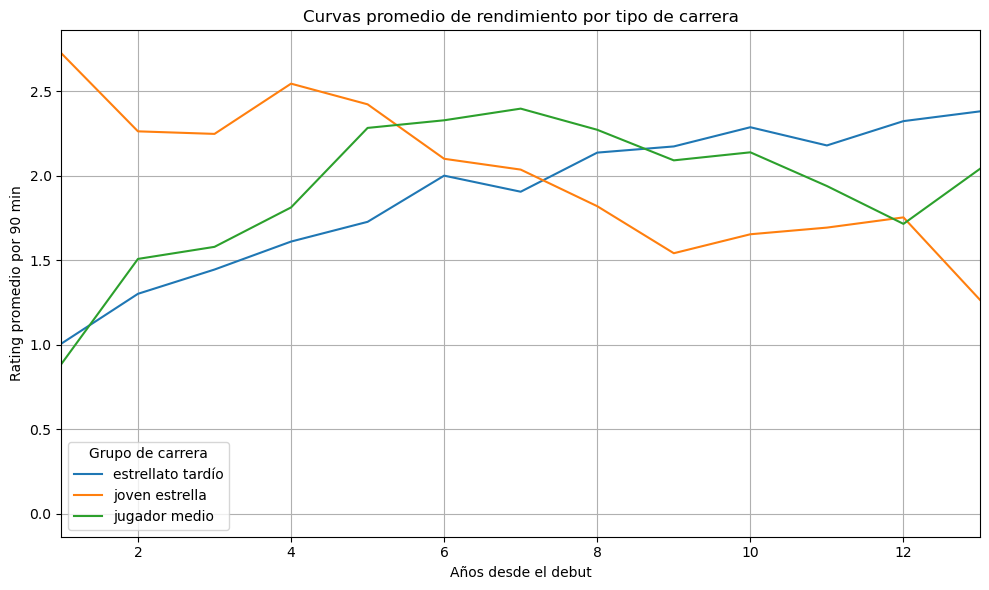

In [14]:
# ----------------------------------------------
# 🎯 Etapa 5: Curvas promedio de rendimiento por tipo de carrera
# ----------------------------------------------
# Objetivo:
# - Construir la trayectoria por año desde el debut para cada jugador
# - Agrupar por tipo de carrera (peak_group)
# - Calcular promedios anuales de rendimiento (rating_per_90)
# - Generar visualización agregada por grupo
# ----------------------------------------------

import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
debut_dates = df[df['Minutes'] > 0].groupby('Player_ID')['Date'].min()
df['debut_year'] = df['Player_ID'].map(debut_dates).dt.year
df['year_since_debut'] = df['Date'].dt.year - df['debut_year'] + 1
df['age'] = (df['Date'] - df['Birth_date']).dt.days / 365.25
df['age_year_1'] = df.groupby('Player_ID')['age'].transform('first')

# ----------------------------------------------
# 🧱 Construcción de career_df: rendimiento año a año desde debut
# ----------------------------------------------

career_df = df.groupby(['Player_ID', 'year_since_debut']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'age_year_1': 'first'
}).reset_index()

# ----------------------------------------------
# 🔁 Añadir grupo de carrera (peak_group)
# ----------------------------------------------
peak_groups = df_season[['Player_ID', 'peak_group']].drop_duplicates()
career_df = career_df.merge(peak_groups, on='Player_ID', how='left')

# ----------------------------------------------
# 📈 Curvas promedio por grupo y año relativo
# ----------------------------------------------
curves = (
    career_df.groupby(['peak_group', 'year_since_debut'])['rating_per_90']
    .mean()
    .reset_index()
)

print("\n📊 Curvas promedio por grupo:")
print(curves.head(10))

# 🖼️ Visualización: rendimiento promedio por grupo (años 1 a 13)
# ----------------------------------------------
plt.figure(figsize=(10, 6))

for group in curves['peak_group'].unique():
    group_data = curves[(curves['peak_group'] == group) & (curves['year_since_debut'] <= 13)]
    plt.plot(
        group_data['year_since_debut'],
        group_data['rating_per_90'],
        label=group
    )

plt.title("Curvas promedio de rendimiento por tipo de carrera")
plt.xlabel("Años desde el debut")
plt.ylabel("Rating promedio por 90 min")
plt.grid(True)
plt.legend(title="Grupo de carrera")
plt.xlim(1, 13)
plt.tight_layout()
plt.show()

# ----------------------------------------------
# ✅ Resultado:
# - career_df contiene la evolución real por jugador desde su debut
# - curves contiene la media por grupo y año (lista para usar como referencia)
# ----------------------------------------------

In [15]:
# ----------------------------------------------
# 🧪 Análisis externo: extracción de jugadores jóvenes con carrera corta 
# Objetivo:
# - Generar lista de jugadores debutantes desde 2020 con 4 o 5 años de carrera
# - Conservar su etiqueta real (peak_group)
# - Usarlos como ejemplos o para validación manual externa
# ----------------------------------------------

import pandas as pd

# 1. Año de debut y duración de carrera
career_span = df_season.groupby('Player_ID')['Calendar_year'].agg(['min', 'max']).reset_index()
career_span['career_length'] = career_span['max'] - career_span['min'] + 1

# 2. Filtrar por carrera corta y debut reciente
career_span = career_span[
    (career_span['career_length'].isin([4, 5])) &
    (career_span['min'] >= 2020)
]

# 3. Añadir peak_group, minutos, rating
peak_labels = df_season[['Player_ID', 'peak_group']].drop_duplicates()
minutes_stats = df_season.groupby('Player_ID')['Minutes'].sum().reset_index().rename(columns={'Minutes': 'total_minutes'})
rating_stats = df_season.groupby('Player_ID')['rating_per_90'].mean().reset_index().rename(columns={'rating_per_90': 'avg_rating'})

revisar_jugadores = (
    career_span
    .merge(peak_labels, on='Player_ID', how='left')
    .merge(minutes_stats, on='Player_ID', how='left')
    .merge(rating_stats, on='Player_ID', how='left')
    .merge(metadata[['Player_ID', 'Player_name', 'Birth_date']], on='Player_ID', how='left')
)

# 4. Calcular edad en 2025
revisar_jugadores['Birth_date'] = pd.to_datetime(revisar_jugadores['Birth_date'], errors='coerce')
revisar_jugadores['age_in_2025'] = (pd.Timestamp("2025-01-01") - revisar_jugadores['Birth_date']).dt.days / 365.25

# 5. Filtrar solo jugadores jóvenes en 2025
revisar_jugadores = revisar_jugadores[revisar_jugadores['age_in_2025'] <= 23]
print(f"🎯 Jugadores jóvenes con carrera corta (2020-2025): {len(revisar_jugadores)}")
print(revisar_jugadores[['Player_ID', 'Player_name', 'peak_group', 'career_length', 'total_minutes', 'avg_rating', 'age_in_2025']].head(30))

🎯 Jugadores jóvenes con carrera corta (2020-2025): 21
   Player_ID            Player_name      peak_group  career_length  \
0   0085841a           Matias Godoy  joven estrella              4   
1   0448c34f       Santiago Hidalgo  joven estrella              4   
3   0757e74b          Julian Eseiza  joven estrella              4   
5   0dfc20ce          Agustin Ojeda  joven estrella              4   
8   125e771a        Gonzalo Morales  joven estrella              4   
11  1dcddc4d           Jose Herrera  joven estrella              4   
21  3fc0e136   Ignacio Maestro Puch  joven estrella              4   
23  468a7a91     Facundo Buonanotte  joven estrella              4   
24  478f8f00            Ivo Mammini  joven estrella              5   
30  6c3e094c           Franco Frias  joven estrella              4   
33  7a39f13b        Fabricio Oviedo  joven estrella              4   
34  7aa8adfe     Alejandro Garnacho  joven estrella              5   
36  83572e83       Julian Fernandez 

In [16]:
# ----------------------------------------------
# 🎯 Etapa 6: Construcción del dataset de modelado
# ----------------------------------------------
# Objetivo:
# - Tomar solo los primeros 3 años desde el debut
# - Pivotar los datos en formato ancho (wide) para modelo tabular
# - Calcular variables derivadas y añadir el grupo objetivo (peak_group)
# ----------------------------------------------

# 1. Seleccionamos los primeros 3 años desde el debut
early_years = career_df[career_df['year_since_debut'] <= 3]

# 2. Pivotamos para transformar años en columnas
pivot_rating = early_years.pivot(index='Player_ID', columns='year_since_debut', values='rating_per_90')
pivot_age = early_years.pivot(index='Player_ID', columns='year_since_debut', values='age_year_1')  # edad constante por jugador
pivot_minutes = early_years.pivot(index='Player_ID', columns='year_since_debut', values='Minutes')

# 3. Renombramos las columnas para consistencia
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]

# 4. Concatenamos todas las características base
df_model = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1)

# Suma de minutos como feature adicional
df_model['minutes_sum'] = df_model[[c for c in df_model.columns if c.startswith('minutes_year_')]].sum(axis=1)


# Factor de fiabilidad por año (minutos entre 600, truncado entre 0 y 1)
for i in [1, 2, 3]:
    min_col = f'minutes_year_{i}'
    if min_col in df_model.columns:
        df_model[f'minutes_weight_{i}'] = df_model[min_col].clip(0, 600) / 600


# ----------------------------------------------
# 5. Variables derivadas (solo si los años existen)
# ----------------------------------------------
if 'rating_year_2' in df_model and 'rating_year_1' in df_model:
    df_model['growth_2_1'] = df_model['rating_year_2'] - df_model['rating_year_1']
if 'rating_year_3' in df_model and 'rating_year_2' in df_model:
    df_model['growth_3_2'] = df_model['rating_year_3'] - df_model['rating_year_2']

# Promedio de rating y suma de minutos totales
df_model['avg_rating'] = df_model[[c for c in df_model.columns if c.startswith('rating_year_')]].mean(axis=1)
df_model['sum_minutes'] = df_model[[c for c in df_model.columns if c.startswith('minutes_year_')]].sum(axis=1)

# Tendencias largas si tenemos años 1 y 3
if 'rating_year_3' in df_model and 'rating_year_1' in df_model:
    df_model['rating_trend'] = df_model['rating_year_3'] - df_model['rating_year_1']
if 'minutes_year_3' in df_model and 'minutes_year_1' in df_model:
    df_model['minutes_trend'] = df_model['minutes_year_3'] - df_model['minutes_year_1']

# ----------------------------------------------
# 6. Añadir variable objetivo (peak_group)
# ----------------------------------------------
df_model = df_model.merge(
    df_season[['Player_ID', 'peak_group']].drop_duplicates(),
    on='Player_ID',
    how='inner'
)

# ----------------------------------------------
# 7. Filtro: jugadores con al menos 1 año con rating
# ----------------------------------------------
rating_cols = [c for c in df_model.columns if c.startswith('rating_year_')]
valid_seasons = df_model[rating_cols].notna().sum(axis=1)
df_model = df_model[valid_seasons >= 1].copy()

# ----------------------------------------------
# 8. Rellenamos nulos restantes (seguro para modelos tipo RandomForest, XGBoost)
# ----------------------------------------------
df_model.fillna(0, inplace=True)

# ----------------------------------------------
# 9. Verificación final
# ----------------------------------------------
print("\n📦 Dataset final para modelado:")
print(df_model.head())

print("\n🎯 Distribución del target (peak_group):")
print(df_model['peak_group'].value_counts())




📦 Dataset final para modelado:
  Player_ID  rating_year_0  rating_year_1  rating_year_2  rating_year_3  \
0  001928b8            0.0       3.913043       0.000000       0.000000   
1  0049be4b            0.0       0.000000       0.000000       0.000000   
2  005ade52            0.0       0.000000      -1.216216       0.000000   
3  0061247c            0.0      -0.424862      -0.441176       0.000000   
4  0085841a            0.0       0.799376       3.894406       0.564313   

   age_year_0  age_year_1  age_year_2  age_year_3  minutes_year_0  ...  \
0         0.0   20.101300    0.000000    0.000000             0.0  ...   
1         0.0    0.000000    0.000000    0.000000             0.0  ...   
2         0.0    0.000000    0.000000    0.000000             0.0  ...   
3         0.0   23.496235   23.496235    0.000000             0.0  ...   
4         0.0   21.048597   21.048597   21.048597             0.0  ...   

   minutes_weight_1  minutes_weight_2  minutes_weight_3  growth_2_1  \
0

In [17]:
print(df_model.columns.tolist())
df_model.head(10)

['Player_ID', 'rating_year_0', 'rating_year_1', 'rating_year_2', 'rating_year_3', 'age_year_0', 'age_year_1', 'age_year_2', 'age_year_3', 'minutes_year_0', 'minutes_year_1', 'minutes_year_2', 'minutes_year_3', 'minutes_sum', 'minutes_weight_1', 'minutes_weight_2', 'minutes_weight_3', 'growth_2_1', 'growth_3_2', 'avg_rating', 'sum_minutes', 'rating_trend', 'minutes_trend', 'peak_group']


,Player_ID,rating_year_0,rating_year_1,rating_year_2,rating_year_3,age_year_0,age_year_1,age_year_2,age_year_3,minutes_year_0,...,minutes_weight_1,minutes_weight_2,minutes_weight_3,growth_2_1,growth_3_2,avg_rating,sum_minutes,rating_trend,minutes_trend,peak_group
0,001928b8,0.0,3.913043,0.000000,0.000000,0.0,20.101300,0.000000,0.000000,0.0,...,0.401667,0.000000,0.000,0.000000,0.000000,3.913043,241.0,0.000000,0.0,joven estrella
1,0049be4b,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.150000,0.300000,0.000,0.000000,0.000000,0.000000,270.0,0.000000,0.0,estrellato tardío
2,005ade52,0.0,0.000000,-1.216216,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.040000,0.153333,0.035,-1.216216,1.216216,-0.405405,137.0,0.000000,-3.0,estrellato tardío
3,0061247c,0.0,-0.424862,-0.441176,0.000000,0.0,23.496235,23.496235,0.000000,0.0,...,0.838333,0.243333,0.000,-0.016314,0.000000,-0.433019,649.0,0.000000,0.0,joven estrella
4,0085841a,0.0,0.799376,3.894406,0.564313,0.0,21.048597,21.048597,21.048597,0.0,...,1.000000,1.000000,1.000,3.095030,-3.330093,1.752698,5224.0,-0.235063,-724.0,joven estrella
5,008e6a07,0.0,1.422877,0.000000,0.000000,0.0,21.253936,0.000000,0.000000,0.0,...,1.000000,0.000000,0.000,0.000000,0.000000,1.422877,985.0,0.000000,0.0,joven estrella
6,00d3206e,0.0,1.710145,-0.369318,-0.103687,0.0,0.000000,0.000000,0.000000,0.0,...,1.000000,1.000000,1.000,-2.079463,0.265632,0.412380,2912.0,-1.813832,-223.0,estrellato tardío
7,00e36323,0.0,-1.730769,0.250771,3.585551,0.0,27.928816,27.928816,27.928816,0.0,...,0.081667,1.000000,1.000,1.981540,3.334781,0.701851,4199.0,5.316320,3008.0,jugador medio
8,00f0e85a,0.0,5.000000,0.000000,0.000000,0.0,31.978097,0.000000,0.000000,0.0,...,0.150000,0.000000,0.000,0.000000,0.000000,5.000000,90.0,0.000000,0.0,estrellato tardío
9,0118dd71,0.0,0.000000,-0.333333,-0.071429,0.0,24.049281,24.049281,24.049281,0.0,...,1.000000,0.450000,1.000,-0.333333,0.261905,-0.134921,2430.0,-0.071429,360.0,estrellato tardío


In [18]:
print("📊 Columnas en df_model (features disponibles):")
print(df_model.columns.tolist())


📊 Columnas en df_model (features disponibles):
['Player_ID', 'rating_year_0', 'rating_year_1', 'rating_year_2', 'rating_year_3', 'age_year_0', 'age_year_1', 'age_year_2', 'age_year_3', 'minutes_year_0', 'minutes_year_1', 'minutes_year_2', 'minutes_year_3', 'minutes_sum', 'minutes_weight_1', 'minutes_weight_2', 'minutes_weight_3', 'growth_2_1', 'growth_3_2', 'avg_rating', 'sum_minutes', 'rating_trend', 'minutes_trend', 'peak_group']


In [19]:
# ----------------------------------------------
# 🎯 Etapa 7: División del dataset y codificación del target
# ----------------------------------------------
# Objetivo:
# - Codificar la variable objetivo (peak_group)
# - Dividir los datos entre entrenamiento y test sin mezclar jugadores
# - Asegurar que la división es estratificada por clase
# ----------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Reestablecer índice por orden
df_model = df_model.reset_index(drop=True)
assert df_model['Player_ID'].is_unique, "⚠️ df_model contiene múltiples filas por jugador. Asegúrate de usar una única fila por jugador."


# 2. Codificar la variable objetivo (peak_group → entero)
le = LabelEncoder()
df_model['peak_group_encoded'] = le.fit_transform(df_model['peak_group'])

# 3. Obtener lista única de jugadores y su clase (para stratify)
player_targets = df_model.drop_duplicates('Player_ID')[['Player_ID', 'peak_group_encoded']]

# 4. División train/test por jugador
train_ids, test_ids = train_test_split(
    player_targets['Player_ID'],
    test_size=0.2,
    stratify=player_targets['peak_group_encoded'],
    random_state=42
)

# 5. Creamos subconjuntos finales (sin fuga de jugadores entre train y test)
train_df = df_model[df_model['Player_ID'].isin(train_ids)].copy()
test_df = df_model[df_model['Player_ID'].isin(test_ids)].copy()

# 6. Separamos X / y
X_train = train_df.drop(columns=['peak_group', 'peak_group_encoded', 'Player_ID'])
y_train = train_df['peak_group_encoded']

X_test = test_df.drop(columns=['peak_group', 'peak_group_encoded', 'Player_ID'])
y_test = test_df['peak_group_encoded']

# ----------------------------------------------
# 🔍 Verificación de tamaño y clases
# ----------------------------------------------
print(f"✅ Train: {X_train.shape[0]} muestras, {train_df['Player_ID'].nunique()} jugadores únicos")
print(f"✅ Test:  {X_test.shape[0]} muestras, {test_df['Player_ID'].nunique()} jugadores únicos")
print(f"🎯 Clases codificadas: {list(le.classes_)}")



✅ Train: 2316 muestras, 2316 jugadores únicos
✅ Test:  580 muestras, 580 jugadores únicos
🎯 Clases codificadas: ['estrellato tardío', 'joven estrella', 'jugador medio']


In [20]:
# Lista de columnas de entrenamiento
print("🧪 Features usados:")
print(X_train.columns.tolist())


🧪 Features usados:
['rating_year_0', 'rating_year_1', 'rating_year_2', 'rating_year_3', 'age_year_0', 'age_year_1', 'age_year_2', 'age_year_3', 'minutes_year_0', 'minutes_year_1', 'minutes_year_2', 'minutes_year_3', 'minutes_sum', 'minutes_weight_1', 'minutes_weight_2', 'minutes_weight_3', 'growth_2_1', 'growth_3_2', 'avg_rating', 'sum_minutes', 'rating_trend', 'minutes_trend']


In [21]:
print("Distribución del target (peak_group):")
print(df_model['peak_group'].value_counts())


Distribución del target (peak_group):
peak_group
estrellato tardío    1605
jugador medio         761
joven estrella        530
Name: count, dtype: int64


In [22]:
# ----------------------------------------------
# 🎯 Etapa 8: Entrenamiento y evaluación de modelos multiclase
# ----------------------------------------------
# Objetivo:
# - Comparar RandomForest, XGBoost y LightGBM con parámetros similares
# - Evaluar rendimiento con métricas robustas
# ----------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef
)

# ----------------------------------------------
# 1. Definición de modelos y parámetros
# ----------------------------------------------
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        num_class=3,
        learning_rate=0.05,
        max_depth=6,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42
    ),
    'LightGBM': LGBMClassifier(
        objective='multiclass',
        num_class=3,
        learning_rate=0.05,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# ----------------------------------------------
# 2. Entrenamiento y evaluación de cada modelo
# ----------------------------------------------
for name, model in models.items():
    print(f"\n🔧 Entrenando modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas principales
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"\n📊 Resultados para {name}:")
    print(f"✅ Accuracy: {acc:.3f}")
    print(f"🧠 Kappa Score: {kappa:.3f}")
    print(f"📈 MCC: {mcc:.3f}")

    # Reporte por clase
    print("\n📄 Clasification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Matriz de confusión
    print("📉 Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))




🔧 Entrenando modelo: RandomForest

📊 Resultados para RandomForest:
✅ Accuracy: 0.703
🧠 Kappa Score: 0.494
📈 MCC: 0.496

📄 Clasification Report:
                   precision    recall  f1-score   support

estrellato tardío       0.82      0.82      0.82       322
   joven estrella       0.66      0.50      0.57       106
    jugador medio       0.51      0.60      0.55       152

         accuracy                           0.70       580
        macro avg       0.66      0.64      0.65       580
     weighted avg       0.71      0.70      0.70       580

📉 Matriz de Confusión:
[[264   7  51]
 [ 17  53  36]
 [ 41  20  91]]

🔧 Entrenando modelo: XGBoost


c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\xgboost\training.py:183: UserWarning: [00:22:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Resultados para XGBoost:
✅ Accuracy: 0.729
🧠 Kappa Score: 0.550
📈 MCC: 0.550

📄 Clasification Report:
                   precision    recall  f1-score   support

estrellato tardío       0.87      0.81      0.84       322
   joven estrella       0.62      0.67      0.65       106
    jugador medio       0.55      0.59      0.57       152

         accuracy                           0.73       580
        macro avg       0.68      0.69      0.68       580
     weighted avg       0.74      0.73      0.73       580

📉 Matriz de Confusión:
[[262  14  46]
 [  7  71  28]
 [ 33  29  90]]

🔧 Entrenando modelo: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4799
[LightGBM] [Info] Number of data points in the train set: 2316, number of used features: 19
[LightGBM] [Info] Start training from score -0.590640
[LightGBM] [Info] Start training from

In [23]:
# ----------------------------------------------
# 🎯 Etapa 9: Limpieza de outliers extremos en ratings
# ----------------------------------------------
# Objetivo:
# - Asegurar que ningún valor de rating por 90 min sea irreal (ej: >10)
# - Recalcular las variables derivadas después de aplicar los límites
# ----------------------------------------------

# 1. Identificamos las columnas de rating (por año + promedio)
rating_cols = [col for col in df_model.columns if col.startswith('rating_year_') or col == 'avg_rating']

# 2. Aplicamos límites razonables (ej: 0 a 10 como escala humana)
for col in rating_cols:
    df_model[col] = df_model[col].clip(lower=0, upper=10)

# 3. Recalculamos variables derivadas (porque el clipping puede haberlas cambiado)
if 'rating_year_2' in df_model and 'rating_year_1' in df_model:
    df_model['growth_2_1'] = df_model['rating_year_2'] - df_model['rating_year_1']
if 'rating_year_3' in df_model and 'rating_year_2' in df_model:
    df_model['growth_3_2'] = df_model['rating_year_3'] - df_model['rating_year_2']

# 4. Verificación de rangos finales
print("\n📊 Verificación de estadísticas tras limpieza:")
print(df_model[rating_cols].describe())



📊 Verificación de estadísticas tras limpieza:
       rating_year_0  rating_year_1  rating_year_2  rating_year_3   avg_rating
count         2896.0    2896.000000    2896.000000    2896.000000  2896.000000
mean             0.0       1.244069       1.111541       1.074791     1.384455
std              0.0       2.006178       1.729819       1.603294     1.725618
min              0.0       0.000000       0.000000       0.000000     0.000000
25%              0.0       0.000000       0.000000       0.000000     0.000000
50%              0.0       0.285714       0.240083       0.291223     0.929309
75%              0.0       1.785220       1.775904       1.728680     1.956078
max              0.0      10.000000      10.000000      10.000000    10.000000


In [24]:
# ----------------------------------------------
# 🎯 Etapa 10: Optimización de RandomForest con RandomizedSearchCV
# ----------------------------------------------
# Objetivo:
# - Buscar la mejor combinación de hiperparámetros para RandomForest
# - Evaluar el rendimiento tras el tuning
# ----------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef
)
import numpy as np

# 1. Espacio de búsqueda (hiperparámetros relevantes)
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 2. Inicializamos el modelo base
rf = RandomForestClassifier(random_state=42)

# 3. RandomizedSearchCV (con validación cruzada y paralelización)
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,               # número de combinaciones a probar
    cv=3,                     # validación cruzada
    verbose=1,
    n_jobs=-1,                # usa todos los núcleos disponibles
    random_state=42
)

# 4. Entrenamiento
print("🔍 Buscando mejores hiperparámetros para RandomForest...")
rf_search.fit(X_train, y_train)

# 5. Evaluación con mejor modelo encontrado
best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n✅ Mejor combinación de hiperparámetros:")
print(rf_search.best_params_)

print("\n📊 Resultados tras tuning:")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("📉 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"🧠 Kappa Score: {cohen_kappa_score(y_test, y_pred):.3f}")
print(f"📈 MCC: {matthews_corrcoef(y_test, y_pred):.3f}")



🔍 Buscando mejores hiperparámetros para RandomForest...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
96 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
53 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constra


✅ Mejor combinación de hiperparámetros:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

📊 Resultados tras tuning:
✅ Accuracy: 0.740

📄 Classification Report:
                   precision    recall  f1-score   support

estrellato tardío       0.89      0.80      0.84       322
   joven estrella       0.64      0.73      0.68       106
    jugador medio       0.56      0.62      0.59       152

         accuracy                           0.74       580
        macro avg       0.69      0.72      0.70       580
     weighted avg       0.76      0.74      0.75       580

📉 Matriz de Confusión:
[[258  14  50]
 [  5  77  24]
 [ 28  30  94]]
🧠 Kappa Score: 0.571
📈 MCC: 0.574


In [25]:
# ----------------------------------------------
# 🎯 Etapa 11: Optimización de RandomForest con GridSearchCV
# ----------------------------------------------
# Objetivo:
# - Probar todas las combinaciones posibles de un grid pequeño y sensato
# - Seleccionar el modelo con mejor rendimiento medio en validación cruzada
# ----------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef
)

# 1. Definimos un grid pequeño pero razonable de hiperparámetros
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [6, 10],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt', 'log2']
}

# 2. Inicializamos el modelo base
rf = RandomForestClassifier(random_state=42)

# 3. GridSearchCV con validación cruzada estratificada
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 4. Entrenamiento del grid
print("🔍 Ejecutando GridSearchCV...")
grid_search.fit(X_train, y_train)

# 5. Evaluación con el mejor estimador encontrado
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# 6. Resultados
print("\n✅ Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)

print("\n📊 Resultados del modelo optimizado:")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("📉 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"🧠 Kappa Score: {cohen_kappa_score(y_test, y_pred):.3f}")
print(f"📈 MCC: {matthews_corrcoef(y_test, y_pred):.3f}")


🔍 Ejecutando GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Mejor combinación de hiperparámetros:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}

📊 Resultados del modelo optimizado:
✅ Accuracy: 0.747

📄 Classification Report:
                   precision    recall  f1-score   support

estrellato tardío       0.89      0.81      0.85       322
   joven estrella       0.64      0.70      0.67       106
    jugador medio       0.57      0.64      0.60       152

         accuracy                           0.75       580
        macro avg       0.70      0.72      0.71       580
     weighted avg       0.76      0.75      0.75       580

📉 Matriz de Confusión:
[[261  15  46]
 [  4  74  28]
 [ 27  27  98]]
🧠 Kappa Score: 0.582
📈 MCC: 0.584


C:\Users\juanm\AppData\Local\Temp\ipykernel_22244\751709336.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


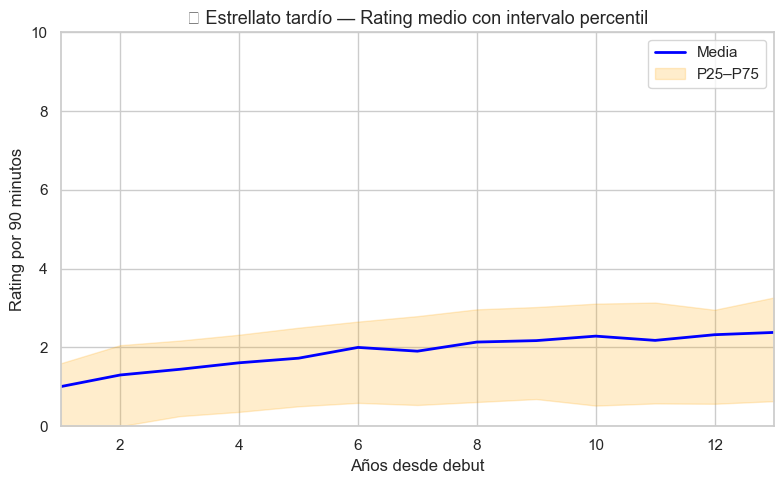

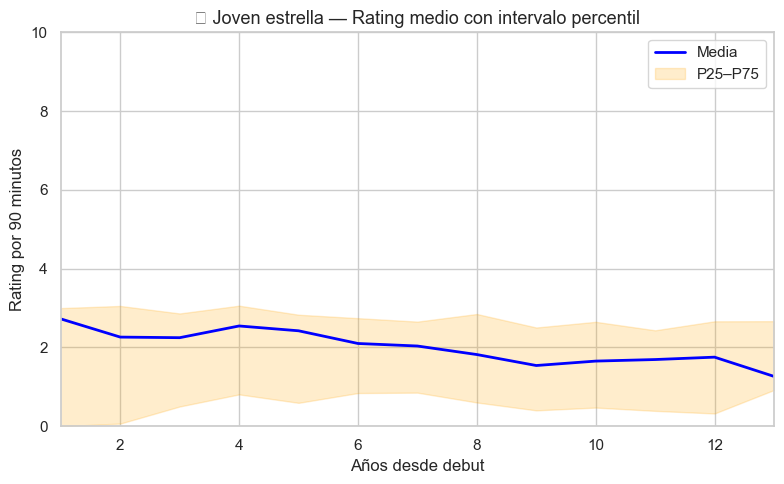

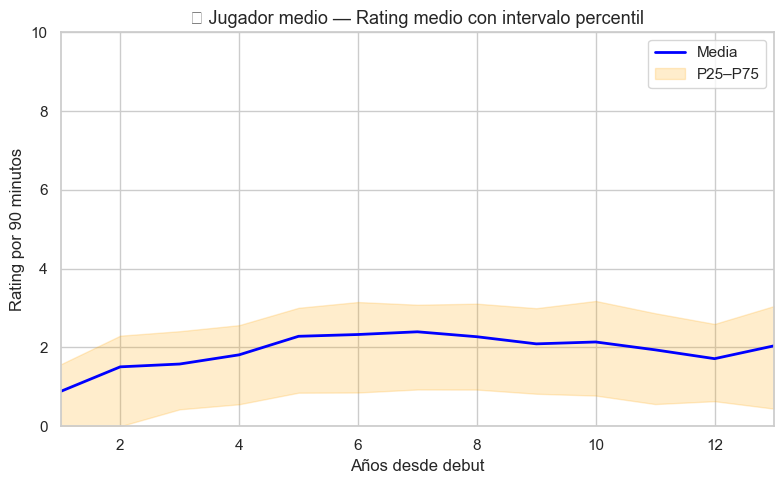

In [26]:
# ----------------------------------------------
# 🎯 Análisis visual de curvas con bandas de variabilidad (P25–P75)
# ----------------------------------------------
# Objetivo:
# - Visualizar el rendimiento medio por grupo (rating_per_90)
# - Añadir bandas de percentiles (25 y 75) como representación de dispersión
# ----------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Agrupamos por grupo y año relativo desde debut
group_stats = career_df.groupby(['peak_group', 'year_since_debut'])['rating_per_90'].agg(
    mean='mean',
    std='std',
    count='count',
    p25=lambda x: np.percentile(x, 25),
    p75=lambda x: np.percentile(x, 75)
).reset_index()

# 2. Limitamos a los primeros 13 años desde debut
group_stats = group_stats[group_stats['year_since_debut'] <= 13]

# ----------------------------------------------
# 3. Gráfica por grupo con bandas percentiles
# ----------------------------------------------
sns.set(style="whitegrid")
unique_groups = group_stats['peak_group'].unique()

for group in unique_groups:
    subset = group_stats[group_stats['peak_group'] == group]

    plt.figure(figsize=(8, 5))

    # Línea media
    plt.plot(
        subset['year_since_debut'], subset['mean'],
        label='Media', color='blue', linewidth=2
    )

    # Banda de percentiles (P25–P75)
    plt.fill_between(
        subset['year_since_debut'],
        subset['p25'],
        subset['p75'],
        color='orange',
        alpha=0.2,
        label='P25–P75'
    )

    # Configuración del gráfico
    plt.title(f"📊 {group.capitalize()} — Rating medio con intervalo percentil", fontsize=13)
    plt.xlabel("Años desde debut")
    plt.ylabel("Rating por 90 minutos")
    plt.xlim(1, 13)
    plt.ylim(0, 10)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [27]:
print("🔍 df_season shape:", df_season.shape)
print("🔍 df_season columnas:", df_season.columns.tolist())
print("🔍 Valores únicos en peak_group:", df_season['peak_group'].unique())
print("🔍 Muestra de df_season:")
display(df_season.head())


🔍 df_season shape: (22044, 11)
🔍 df_season columnas: ['Player_ID', 'Calendar_year', 'Minutes', 'Goals', 'Assists', 'rating_per_90', 'Age', 'peak_year', 'peak_rating', 'age_at_peak', 'peak_group']
🔍 Valores únicos en peak_group: ['joven estrella' 'estrellato tardío' 'jugador medio']
🔍 Muestra de df_season:


,Player_ID,Calendar_year,Minutes,Goals,Assists,rating_per_90,Age,peak_year,peak_rating,age_at_peak,peak_group
0,001928b8,2015,241.0,1.0,0.0,3.913043,20.262286,2015,3.913043,20.262286,joven estrella
1,0049be4b,2014,90.0,0.0,0.0,0.000000,NaN,2014,0.000000,NaN,estrellato tardío
2,0049be4b,2015,180.0,0.0,0.0,0.000000,NaN,2014,0.000000,NaN,estrellato tardío
3,0049be4b,2017,721.0,0.0,0.0,-0.083333,NaN,2014,0.000000,NaN,estrellato tardío
4,0049be4b,2018,154.0,0.0,0.0,-0.500000,NaN,2014,0.000000,NaN,estrellato tardío


In [28]:
# ----------------------------------------------
# 🎯 Etapa final: Guardado de modelo y recursos
# ----------------------------------------------

import joblib
from pathlib import Path
import numpy as np

# 1. Ruta donde se guardan los objetos del modelo
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# 2. Aseguramos cuál es el mejor modelo (elige manualmente cuál usar)
final_model = grid_search.best_estimator_  # puedes cambiar esto a model, rf_search.best_estimator_, etc.

# 3. Guardamos el modelo entrenado
joblib.dump(final_model, 'model/futpeak_model_multi.joblib')

# 4. Guardamos el label encoder
joblib.dump(le, model_dir / "label_encoder.joblib")

# 5. Guardamos las columnas utilizadas para entrenar el modelo
joblib.dump(X_train.columns.tolist(), model_dir / "model_features.joblib")

# 6. Generamos las curvas promedio por grupo (de nuevo, con year_since_debut)
debut_years = df_season.groupby('Player_ID')['Calendar_year'].min().to_dict()
df_season = df_season.copy()
df_season['year_since_debut'] = df_season['Player_ID'].map(debut_years)
df_season['year_since_debut'] = df_season['Calendar_year'] - df_season['year_since_debut'] + 1

# ⚠️ Validar que no haya NaNs
df_season = df_season[df_season['year_since_debut'].notna()]

# Crear curvas
df_curves = (
    df_season.groupby(['peak_group', 'year_since_debut'])['rating_per_90']
    .agg(
        rating_avg='mean',
        rating_p25=lambda x: np.percentile(x, 25),
        rating_p75=lambda x: np.percentile(x, 75)
    )
    .reset_index()
)

# Guardar
joblib.dump(df_curves, 'model/curvas_promedio.joblib')
print("✅ Curvas promedio guardadas correctamente.")


print("✅ Modelo, encoder, columnas y curvas promedio guardados correctamente.")


✅ Curvas promedio guardadas correctamente.
✅ Modelo, encoder, columnas y curvas promedio guardados correctamente.


In [29]:
import os
print("📁 ¿Existe el archivo después de guardar?", os.path.exists("model/curvas_promedio.joblib"))


📁 ¿Existe el archivo después de guardar? True


In [30]:
print(df_curves.shape)
df_curves


(65, 5)


,peak_group,year_since_debut,rating_avg,rating_p25,rating_p75
0,estrellato tardío,1,1.006978,0.000000,1.599082
1,estrellato tardío,2,1.301708,0.000000,2.057956
2,estrellato tardío,3,1.445364,0.255912,2.174746
3,estrellato tardío,4,1.610954,0.364241,2.323323
4,estrellato tardío,5,1.727788,0.505867,2.501532
...,...,...,...,...,...
60,jugador medio,15,2.146045,0.352419,3.599442
61,jugador medio,16,2.579704,1.247193,4.310544
62,jugador medio,17,1.606819,0.000000,2.730848
63,jugador medio,18,0.588965,0.000000,0.883448


In [31]:
# Cuántos jugadores aportan datos a cada year_since_debut
players_per_year = career_df.groupby('year_since_debut')['Player_ID'].nunique().reset_index()
players_per_year.columns = ['Año desde debut', 'Nº jugadores']
print(players_per_year)



    Año desde debut  Nº jugadores
0                 0             1
1                 1          2896
2                 2          2131
3                 3          1901
4                 4          1852
5                 5          1818
6                 6          1720
7                 7          1717
8                 8          1662
9                 9          1591
10               10          1410
11               11          1065
12               12           737
13               13           456
14               14           344
15               15           254
16               16           183
17               17           129
18               18            83
19               19            44
20               20            26
21               21            13
22               22             8
23               23             2
24               25             1


In [32]:
minutes_by_year = career_df.groupby('year_since_debut')['Minutes'].mean().reset_index()
print(minutes_by_year.head(20))


    year_since_debut      Minutes
0                  0     0.000000
1                  1   555.504144
2                  2  1109.576255
3                  3  1348.381904
4                  4  1490.264039
5                  5  1547.903740
6                  6  1615.969767
7                  7  1610.504950
8                  8  1650.320096
9                  9  1566.549340
10                10  1403.300709
11                11  1364.294836
12                12  1256.332429
13                13  1347.956140
14                14  1363.816860
15                15  1384.188976
16                16  1314.819672
17                17  1300.054264
18                18  1253.373494
19                19  1300.386364


In [33]:
# Verificar cálculo del año de debut
df_tmp = df.copy()
df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
df_tmp['Natural_year'] = df_tmp['Date'].dt.year

# Agregamos debut por jugador
debut_by_player = df_tmp[df_tmp['Minutes'] > 0].groupby('Player_ID')['Natural_year'].min().reset_index()
debut_by_player.columns = ['Player_ID', 'Debut_year']

# Merge para revisar
df_debug = df_tmp.merge(debut_by_player, on='Player_ID')
df_debug['year_since_debut'] = df_debug['Natural_year'] - df_debug['Debut_year'] + 1

# Ahora buscamos valores extraños
print("\nJugadores con year_since_debut > 15:")
print(df_debug[df_debug['year_since_debut'] > 15][['Player_name', 'Natural_year', 'Debut_year', 'year_since_debut']].drop_duplicates())



Jugadores con year_since_debut > 15:
               Player_name  Natural_year  Debut_year  year_since_debut
139745       Sergio Agüero          2021        2006                16
143108         Rubén Ayala          1998        1974                25
146725   Gonzalo Bergessio          2022        2007                16
151909     Pablo Calandria          2016        2001                16
151933     Pablo Calandria          2017        2001                17
...                    ...           ...         ...               ...
467209      Fabio Ceravolo          2021        2005                17
467497       Alessio Cerci          2019        2004                16
467595       Alessio Cerci          2020        2004                17
470307  Marco D'Alessandro          2024        2009                16
470319  Marco D'Alessandro          2025        2009                17

[489 rows x 4 columns]


In [34]:
# Jugadores con más edad al final de su carrera
print("\nJugadores con mayor edad en dataset:")
print(df.groupby("Player_ID")["Age"].max().sort_values(ascending=False).head(10))



Jugadores con mayor edad en dataset:
Player_ID
a20a0ee8    48.484600
5553259e    48.459959
29cf8777    43.318275
3b64f69d    41.856263
4cd813d5    41.848049
7768235d    41.544148
6a11048a    41.004791
6d4d9e18    40.859685
d7f6f201    40.758385
7a4cea18    40.613279
Name: Age, dtype: float64
